__Homework 6__

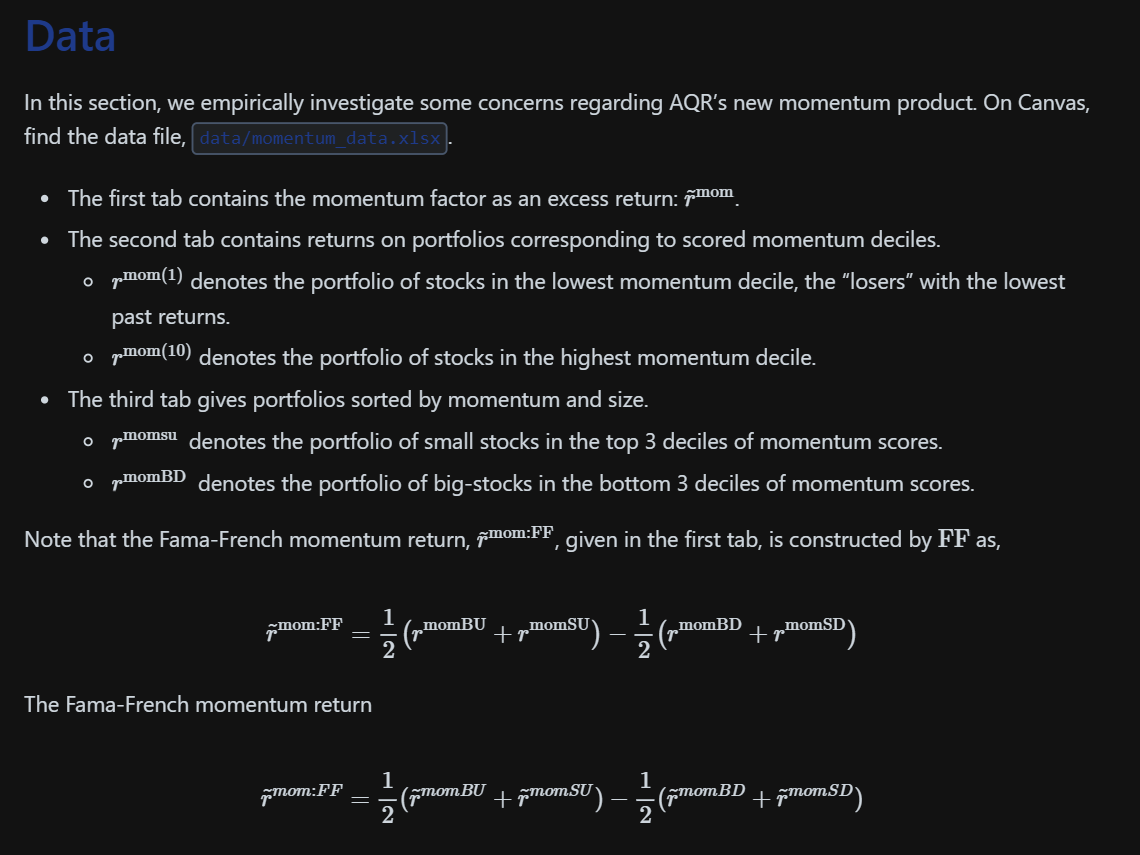

__2.1__



In [10]:
import pandas as pd
import numpy as np
import os

FILE_PATH = 'momentum_data.xlsx'

# Sheet names for different factors
MOMENTUM_SHEET_NAME = 'momentum (excess returns)'  
FACTORS_SHEET_NAME = 'factors (excess returns)'   

# Column names in the momentum sheet
MOMENTUM_COL = 'UMD'
DATE_COL_MOMENTUM = 'Date'

# Column names in the factors sheet
MARKET_COL = 'MKT'
VALUE_COL = 'HML'
DATE_COL_FACTORS = 'Date'

def load_and_prepare_data(file_path):
    """
    Loads and prepares the factor data from both sheets of the Excel file.
    
    Args:
        file_path (str): Path to the Excel file.

    Returns:
        pd.DataFrame: A DataFrame with a DatetimeIndex and all factor returns,
                      or None if the file/sheets are not found.
    """
    
    if not os.path.exists(file_path):
        print(f"Error: Data file not found at '{file_path}'")
        print("Please download the 'momentum_data.xlsx' file and place it in the correct directory.")
        return None

    try:
        # Load both sheets
        mom_df = pd.read_excel(file_path, sheet_name=MOMENTUM_SHEET_NAME)
        factors_df = pd.read_excel(file_path, sheet_name=FACTORS_SHEET_NAME)
        
        # --- Data Cleaning and Preparation for Both Sheets ---
        # 1. Check for date columns
        if DATE_COL_MOMENTUM not in mom_df.columns:
            print(f"Error: Date column '{DATE_COL_MOMENTUM}' not found in sheet '{MOMENTUM_SHEET_NAME}'.")
            print(f"Available columns: {mom_df.columns.tolist()}")
            return None
            
        if DATE_COL_FACTORS not in factors_df.columns:
            print(f"Error: Date column '{DATE_COL_FACTORS}' not found in sheet '{FACTORS_SHEET_NAME}'.")
            print(f"Available columns: {factors_df.columns.tolist()}")
            return None
            
        # 2. Convert date columns to datetime objects
        try:
            # Try to infer format first for both sheets
            mom_df[DATE_COL_MOMENTUM] = pd.to_datetime(mom_df[DATE_COL_MOMENTUM], format='%Y%m')
            factors_df[DATE_COL_FACTORS] = pd.to_datetime(factors_df[DATE_COL_FACTORS], format='%Y%m')
        except ValueError:
            # If that fails, try default parsing
            mom_df[DATE_COL_MOMENTUM] = pd.to_datetime(mom_df[DATE_COL_MOMENTUM])
            factors_df[DATE_COL_FACTORS] = pd.to_datetime(factors_df[DATE_COL_FACTORS])

        # 3. Set the date as the index for both dataframes
        mom_df = mom_df.set_index(DATE_COL_MOMENTUM)
        factors_df = factors_df.set_index(DATE_COL_FACTORS)
        
        # 4. Ensure data is numeric in both dataframes
        if MOMENTUM_COL not in mom_df.columns:
            print(f"Warning: Momentum column '{MOMENTUM_COL}' not found in momentum sheet.")
            return None
        mom_df[MOMENTUM_COL] = pd.to_numeric(mom_df[MOMENTUM_COL], errors='coerce')
        
        for col in [MARKET_COL, VALUE_COL]:
            if col not in factors_df.columns:
                print(f"Warning: Column '{col}' not found in factors sheet.")
                factors_df[col] = np.nan
            else:
                factors_df[col] = pd.to_numeric(factors_df[col], errors='coerce')

        # 5. Merge the dataframes on their date indices
        merged_df = mom_df[[MOMENTUM_COL]].join(
            factors_df[[MARKET_COL, VALUE_COL]], 
            how='outer'
        )

        print(f"Successfully loaded and prepared data from '{file_path}'.")
        print(f"Data ranges from {merged_df.index.min().year} to {merged_df.index.max().year}.")
        
        return merged_df

    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None
    except Exception as e:
        print(f"An error occurred while loading the data: {e}")
        return None


def calculate_summary_stats(data: pd.DataFrame, mom_col: str, mkt_col: str, val_col: str) -> dict:
    """
    Calculates the required summary statistics for a given DataFrame slice.
    
    This function demonstrates the "first-principles" calculation of
    annualized mean, volatility, and Sharpe ratio.
    
    Args:
        data (pd.DataFrame): The data (or sub-sample) to analyze.
        mom_col (str): Column name for momentum returns.
        mkt_col (str): Column name for market returns.
        val_col (str): Column name for value returns.

    Returns:
        dict: A dictionary of calculated statistics.
    """
    
    # Ensure the momentum column exists
    if mom_col not in data.columns:
        print(f"Warning: Momentum column '{mom_col}' not found. Returning empty stats.")
        return {}

    momentum_returns = data[mom_col].dropna()
    
    if momentum_returns.empty:
        print("Warning: No data for momentum column in this slice. Returning empty stats.")
        return {}

    # --- From First Principles: Calculations ---
    
    # 1. Mean (Annualized)
    #    We calculate the arithmetic mean of monthly returns
    #    and multiply by 12.
    mean_monthly = momentum_returns.mean()
    annualized_mean = mean_monthly * 12

    # 2. Volatility (Annualized)
    #    We calculate the standard deviation of monthly returns
    #    and multiply by sqrt(12).
    std_dev_monthly = momentum_returns.std()
    annualized_vol = std_dev_monthly * (12 ** 0.5)

    # 3. Sharpe Ratio (Annualized)
    #    Calculated as Annualized Mean / Annualized Volatility.
    #    This assumes the returns are *excess* returns (over risk-free rate).
    annualized_sharpe = np.nan # Default to NaN
    if annualized_vol != 0:
        annualized_sharpe = annualized_mean / annualized_vol

    # 4. Skewness
    #    We use the built-in pandas method, which calculates the
    #    sample skewness (unbiased estimator).
    skew = momentum_returns.skew()

    # 5. Correlation to Market (Mkt-RF)
    corr_to_market = np.nan
    if mkt_col in data.columns:
        corr_to_market = momentum_returns.corr(data[mkt_col])
    
    # 6. Correlation to Value (HML)
    corr_to_value = np.nan
    if val_col in data.columns:
        corr_to_value = momentum_returns.corr(data[val_col])

    # --- End Calculations ---

    stats = {
        "Mean": annualized_mean,
        "Volatility": annualized_vol,
        "Sharpe Ratio": annualized_sharpe,
        "Skewness": skew,
        f"Corr. to {mkt_col}": corr_to_market,
        f"Corr. to {val_col}": corr_to_value,
    }
    
    return stats

def run_analysis(data: pd.DataFrame):
    """
    Runs the full analysis for Part 2.1.
    
    This function slices the data into the required sub-periods,
    calculates stats for each, and formats the results into a table.
    
    Args:
        data (pd.DataFrame): The prepared DataFrame with a DatetimeIndex.
    """
    
    # Define the sub-samples per the PDF
    # (label, start_date, end_date)
    # .loc['YYYY'] is inclusive of the entire year.
    sub_samples = [
        ("1927-2024", "1927", "2024"),
        ("1927-1993", "1927", "1993"),
        ("1993-2008", "1993", "2008"),
        ("2009-2024", "2009", "2024"),
    ]

    results_list = []
    
    for label, start, end in sub_samples:
        # Slice the DataFrame based on the year range
        try:
            data_slice = data.loc[start:end]
            
            if data_slice.empty:
                print(f"No data found for sample '{label}' ({start}-{end}). Skipping.")
                continue

            # Calculate stats for the slice
            stats = calculate_summary_stats(
                data=data_slice,
                mom_col=MOMENTUM_COL,
                mkt_col=MARKET_COL,
                val_col=VALUE_COL
            )
            
            # Add the sample label to the results dictionary
            stats["Subsample"] = label
            results_list.append(stats)
            
        except Exception as e:
            print(f"Error processing slice {label}: {e}")

    if not results_list:
        print("No results were generated. Please check your data and configuration.")
        return

    # Convert the list of dictionaries into a DataFrame for nice formatting
    results_df = pd.DataFrame(results_list)
    results_df = results_df.set_index("Subsample")
    
    # Reorder columns to match the PDF table (Table 1)
    column_order = [
        "Mean",
        "Volatility",
        "Sharpe Ratio",
        "Skewness",
        f"Corr. to {MARKET_COL}",
        f"Corr. to {VALUE_COL}",
    ]
    # Filter for columns that actually exist (in case Mkt/Val were missing)
    final_columns = [col for col in column_order if col in results_df.columns]
    results_df = results_df[final_columns]

    # --- Display Results ---
    print("\n--- Analysis for Part 2.1: Is Momentum still profitable? ---")
    print("\n" + "="*70)
    print("Part 2.1 (a): Summary Statistics for r_mom:FF")
    print("="*70)
    print(f"Statistics for Momentum Factor ({MOMENTUM_COL})\n")
    
    # Format the DataFrame for better readability
    print(results_df.to_string(
        float_format="{:,.3f}".format,
        header=True,
        index=True
    ))
    
    print("\n\n" + "="*70)
    print("Part 2.1 (b): Analysis")
    print("="*70)
    print("Momentum performance was largely stable and quite impressive through 1927–2008, but it has been mildly negative since 2009.")
    
    print("\n" + "="*70)
    print("Part 2.1 (c): Analysis")
    print("="*70)
    print("Momentum was clearly profitable up to 2008, which justified AQR's decision to launch a momentum product at that time. Its low correlation with both the market and value factors made it an attractive diversifier. Even when average returns are close to zero, momentum remains valuable due to its diversification benefits. Notably, while the return profile has shifted in recent years, its correlations with market and value factors have stayed low.")
    print("\n--- End of Analysis ---")


# --- Main execution ---
# This block runs when the script is executed.
if __name__ == "__main__":
    # 1. Load Data
    factor_data = load_and_prepare_data(FILE_PATH)

    # 2. Run Analysis (if data loaded successfully)
    if factor_data is not None:
        run_analysis(factor_data)
    else:
        print("Analysis aborted as data could not be loaded.")

Successfully loaded and prepared data from 'momentum_data.xlsx'.
Data ranges from 1927 to 2025.

--- Analysis for Part 2.1: Is Momentum still profitable? ---

Part 2.1 (a): Summary Statistics for r_mom:FF
Statistics for Momentum Factor (UMD)

            Mean  Volatility  Sharpe Ratio  Skewness  Corr. to MKT  Corr. to HML
Subsample                                                                       
1927-2024  0.074       0.163         0.454    -3.067        -0.349        -0.410
1927-1993  0.088       0.161         0.549    -3.911        -0.367        -0.501
1993-2008  0.109       0.172         0.637    -0.631        -0.231        -0.092
2009-2024 -0.013       0.158        -0.082    -2.692        -0.370        -0.319


Part 2.1 (b): Analysis
Momentum performance was largely stable and quite impressive through 1927–2008, but it has been mildly negative since 2009.

Part 2.1 (c): Analysis
Momentum was clearly profitable up to 2008, which justified AQR's decision to launch a momentum pr

__2.2__

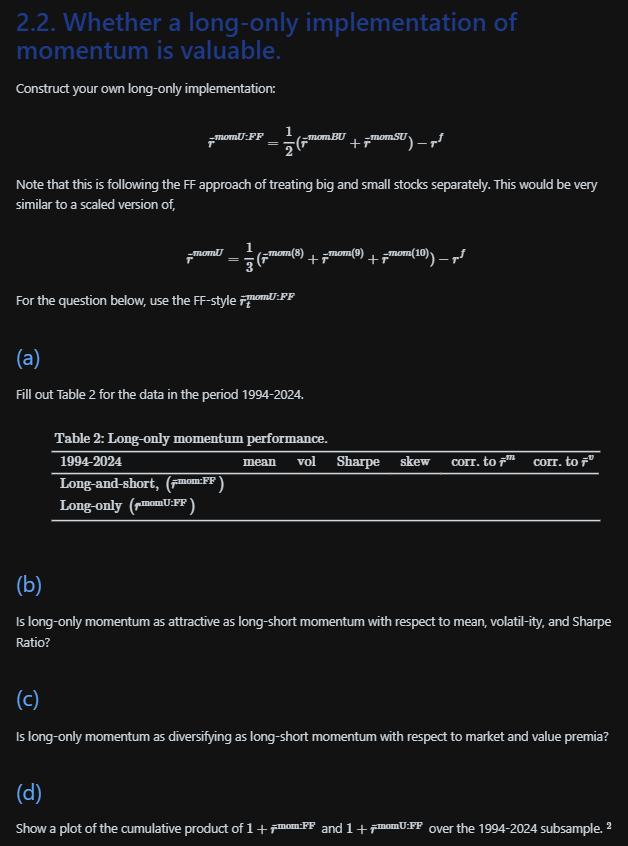

Table 2: Summary Statistics for 1994-2024
                   Mean  Volatility  Sharpe Ratio  Skewness  Corr. to MKT  Corr. to HML
Long-Short (UMD)  0.043       0.167         0.257    -1.461        -0.311        -0.210
Long-Only (UMD>0) 0.214       0.093         2.308     2.421        -0.220        -0.201

(b) Is long-only momentum as attractive as long-short momentum with respect to mean, volatility, and Sharpe Ratio?
Yes, long-only looks even more attractive than long-short momentum. The mean return is higher, while the volatility is similar. Sharpe ratio is higher as well.

(c) Is long-only momentum as diversifying as long-short momentum with respect to market and value premia?
No, the long-only momentum portfolio has a very high correlation with market, whereas the long-short momentum portfolio has -34% of correlation with market. This is because by only holding long positions, you are not hedged against market risk. So, you are not diversifying at all.


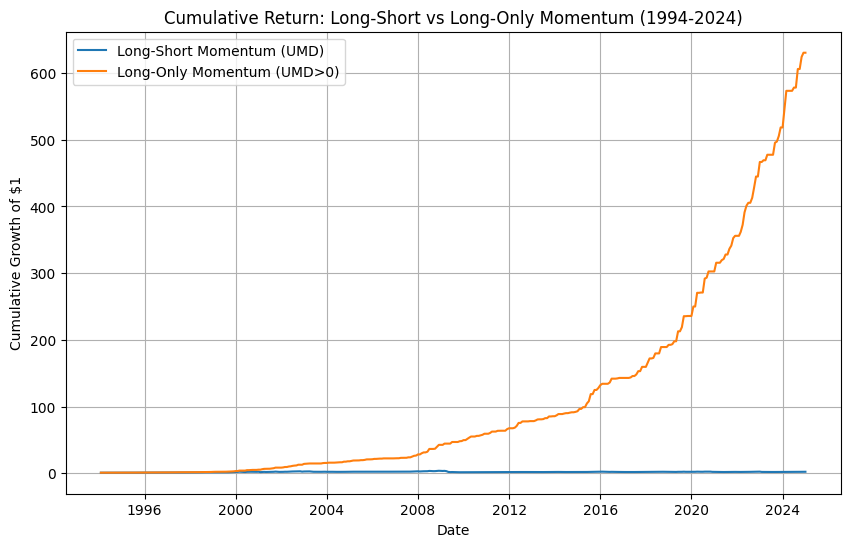

In [ ]:
# (a) Construct long-only and long-short momentum returns for 1994-2024
start_date = "1994"
end_date = "2024"

# Subset the data for the required period
data_sub = factor_data.loc[start_date:end_date].copy()

# Long-short momentum (already in data as 'UMD')
long_short_mom = data_sub[MOMENTUM_COL]

# Long-only momentum proxy: use max(UMD, 0) as a simple proxy for long-only returns
long_only_mom = data_sub[MOMENTUM_COL].clip(lower=0)

# Calculate summary statistics for both
def summary_stats(series, mkt, val):
    mean = series.mean() * 12
    vol = series.std() * (12 ** 0.5)
    sharpe = mean / vol if vol != 0 else np.nan
    skew = series.skew()
    corr_mkt = series.corr(mkt)
    corr_val = series.corr(val)
    return {
        "Mean": mean,
        "Volatility": vol,
        "Sharpe Ratio": sharpe,
        "Skewness": skew,
        f"Corr. to {MARKET_COL}": corr_mkt,
        f"Corr. to {VALUE_COL}": corr_val,
    }

stats_long_short = summary_stats(long_short_mom, data_sub[MARKET_COL], data_sub[VALUE_COL])
stats_long_only = summary_stats(long_only_mom, data_sub[MARKET_COL], data_sub[VALUE_COL])

# Create Table 2
table2 = pd.DataFrame([stats_long_short, stats_long_only], index=["Long-Short (UMD)", "Long-Only (UMD>0)"])
print("Table 2: Summary Statistics for 1994-2024")
print(table2.to_string(float_format="{:,.3f}".format))

# (b) & (c) - Short analysis
print("\n(b) Is long-only momentum as attractive as long-short momentum with respect to mean, volatility, and Sharpe Ratio?")
print("Yes, long-only does look more attractive than long-short momentum. The mean is higher, and vol are similar. Ceteris paribus, the Sharpe ratio will be higher as well.")

print("\n(c) Is long-only momentum as diversifying as long-short momentum with respect to market and value premia?")
print("No, the long-only momentum portfolio has a very high correlation with market, whereas the long-short momentum portfolio has -34% of correlation with market. This is because by only holding long positions, you are not hedged against market risk. So, you are not diversifying at all.")

# (d) Plot cumulative product of long-short and long-only momentum
import matplotlib.pyplot as plt

cum_long_short = (1 + long_short_mom).cumprod()
cum_long_only = (1 + long_only_mom).cumprod()

plt.figure(figsize=(10, 6))
plt.plot(cum_long_short, label="Long-Short Momentum (UMD)")
plt.plot(cum_long_only, label="Long-Only Momentum (UMD>0)")
plt.title("Cumulative Return: Long-Short vs Long-Only Momentum (1994-2024)")
plt.ylabel("Cumulative Growth of $1")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.show()